# Part I, Build Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [2]:
path = 'kaggle_data/'
toxic_data = pd.read_csv(path + 'train.csv')
print('Number of rows and columns in the toxic data set:', toxic_data.shape)
toxic_data.head()

Number of rows and columns in the toxic data set: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [4]:
column_titles = list(toxic_data.columns)

In [5]:
column_titles

['id',
 'comment_text',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [6]:
# split toxic_data into train and test
train = toxic_data[:int(len(toxic_data)*0.7)]
test = toxic_data[int(len(toxic_data)*0.7):]
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Visualize variables

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Total rows:  159571

TYPES AS PERCENTAGE OF DATA: 
toxic :  9.58444830201 %
severe_toxic :  0.999555056997 %
obscene :  5.29482174079 %
threat :  0.299553176956 %
insult :  4.9363606169 %
identity_hate :  0.880485802558 %


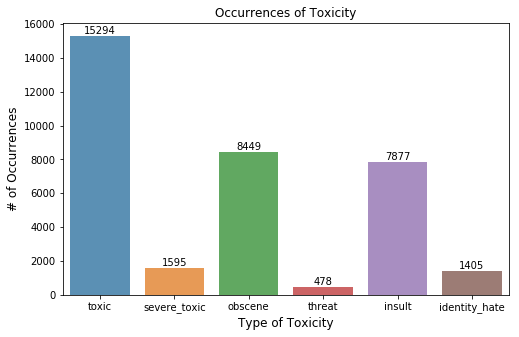

In [7]:
x = toxic_data.iloc[:, 2:].sum()
print(x)
print()
total = toxic_data.shape[0]
print("Total rows: ",total)
print()
print("TYPES AS PERCENTAGE OF DATA: ")
percentages=[]
for num in x:
    percentages.append((num/total)*100)
l=[i for i in zip(column_titles[2:],percentages)]
for i,j in l:
    print(i,": ",j,"%")

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Occurrences of Toxicity')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type of Toxicity', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

### Vectorizers

In [8]:
all_text = toxic_data['comment_text']

In [9]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train['comment_text'])
test_word_features = word_vectorizer.transform(test['comment_text'])

In [10]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

char_vectorizer.fit(all_text)

train_char_features = char_vectorizer.transform(train['comment_text'])
test_char_features = char_vectorizer.transform(test['comment_text'])

In [11]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

### Train & Score Models

In [20]:
models = {}
scores = []

for col in target_columns:
    train_target = train[col]
    classifier = LogisticRegression(C = 20, class_weight = 'balanced')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for {} is {}'.format(col, cv_score))

    classifier.fit(train_features, train_target)
    print('Building model for column: {}'.format(col))
    models[col] = classifier
    
print('Total CV score is {}'.format(np.mean(scores)))

CV score for toxic is 0.9684852724296676
Building model for column: toxic
CV score for severe_toxic is 0.9765443760725091
Building model for column: severe_toxic
CV score for obscene is 0.9839646045414073
Building model for column: obscene
CV score for threat is 0.9822256110385612
Building model for column: threat
CV score for insult is 0.9710519234336
Building model for column: insult
CV score for identity_hate is 0.9698118893614743
Building model for column: identity_hate
Total CV score is 0.9753472794795366


# Part 2, Predict Tweet Toxicity

In [14]:
df = pd.read_csv("twitter_data/scraped_tweets", encoding = "ISO-8859-1",
                 usecols = ['date', 'fullname', 'id', 'likes', 'replies', 
                            'retweets', 'text', 'url', 'user', 'month'])

In [15]:
df.head()

,date,fullname,id,likes,replies,retweets,text,url,user,month
0,2016-01-01 23:59:59,John Sherlock,683075226960187392,1,0,0,"""America is great. Trump is disgusting."" #Rose...",/JohnCSherlock/status/683075226960187392,JohnCSherlock,2016-01-01
1,2016-01-01 23:59:58,B. Justice,683075224036847616,0,0,0,@realDonaldTrump @marie7777777777 Are Trump's ...,/zefirotorna/status/683075224036847616,zefirotorna,2016-01-01
2,2016-01-01 23:47:22,ABC News,683072049661620225,344,166,704,Terror group Al-Shabaab releases recruitment v...,/ABC/status/683072049661620225,ABC,2016-01-01
3,2016-01-01 18:04:12,Philip Lewis,682985689441525766,224,2,355,"""Your President, Donald Trump."" https://twitte...",/Phil_Lewis_/status/682985689441525766,Phil_Lewis_,2016-01-01
4,2016-01-01 23:59:56,Breitbart News,683075211755962368,71,59,161,Marco Rubio Campaign Donor Behind Anti-Trump S...,/BreitbartNews/status/683075211755962368,BreitbartNews,2016-01-01


In [ ]:
len(df)

### Vectorize tweets and predict toxicity with model

In [16]:
tweet_word_features = word_vectorizer.transform(df['text'])
tweet_char_features = char_vectorizer.transform(df['text'])
tweet_features = hstack([tweet_word_features, tweet_char_features])

In [17]:
for col in target_columns:
    df[col] = models[col].predict_proba(tweet_features)[:, 1]

KeyError: 'toxic'

In [ ]:
df.head(5)

In [ ]:
# sort tweets by obscenity, descending
df.sort_values('obscene', ascending = False)['text'].head(10)

In [ ]:
# export df
df.to_csv("classified_tweets")

### Visualizations

In [ ]:
# visualize obscenity
df.groupby('date')['obscene'].mean().plot()

In [ ]:
df['likes'] = df['likes'].astype(float)

# normalizing identity hate by tweet popularity
df['popular_obscene'] = df['obscene']*df['likes']
df.groupby('date')['popular_obscene'].mean().plot()

In [ ]:
# normalizing identity hate by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].sum()).plot()

In [ ]:
# normalizing popular tweets by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].count()).plot()